# Monitoring long-term changes of precipitation in support of rain-fed farming

### Quality question:
 - __What is the uncertainty of the observed precipitation trend over the Sahel region?__


Precipitation is a fundamental component of the hydrological cycle. It significantly influences ecosystems, agriculture, water resources, and weather patterns. In recent decades, climate change has been altering precipitation patterns globally, resulting in shifts in intensity, frequency, and distribution.
Monitoring and understanding the precipitation changes are crucial for predicting future climate impacts and formulating adaptive strategies.
Satellite remote sensing has played a crucial role in this regard, providing comprehensive data on global precipitation. Unlike in situ measurements, which are limited to specific locations, satellite measurements offer extensive coverage across the globe, including remote and oceanic regions [2,3]. 
<!-- This comprehensive data allows for a more complete and accurate assessment of precipitation, enhancing our understanding of how climate change is modifying precipitation patterns and aiding in effective response planning. -->


The Global Precipitation Climatology Project (GPCP) is an international initiative aimed at providing accurate, long-term records of global precipitation [1].
Estimate of precipitation intensity is obtained by the combination of microwave imagers on polar-orbiting satellites and infrared imagers on geostationary satellites from 1979. 
The dataset is available on the Copernicus Data Store (CDS) at [__Precipitation monthly and daily gridded data from 1979 to present derived from satellite measurements__](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-precipitation?tab=overview).


The following notebook provides a clear example of computing the precipitation trend, considering the uncertainties present in the dataset. This ensures an accurate estimation of the uncertainty in the fitted trend.

The analysis focuses on the Sahel region, located between the Sahara Desert to the north and the humid tropical savanna to the south. The Sahel is a critical area for monitoring precipitation trends due to its significant dependence on the Hadley cell circulation. Additionally, this region experiences large interannual and decadal variability in rainfall, which profoundly impacts agriculture, water resources, and living conditions. Monitoring precipitation trends in the Sahel is essential for understanding the effects of climate change and for developing effective water management and agricultural strategies to enhance food security for the local population.
<!--The analysis focuses on the Sahel region, but the geolocation can be adjusted to study any region of interest.-->


## Quality assessment statement 

These are the key outcomes of this assessment

- Over the Sahel region, precipitation has increased by 0.0891 ± 0.0036 mm/day per decade during the period from 1980 to 2020. The exact value of the precipitation trend over the Sahel depends on the defined domain limits and the specific time period considered. The trend obtained in this analysis is significantly positive and it aligns with the values reported [[3](https://doi.org/10.1007/s00382-022-06567-9), [5](https://doi.org/10.1002/wcc.591)].

- The uncertainty on the value of the precipitation trend is 0.0036 mm/day. The 95% confidence interval for the precipitation trend is between 0.00818 and 0.00964 mm/day. The obtained p-value is $6.37 \times 10^{-5}$, suggesting that the increasing trend is highly statistically significant. The Kendall tau test resulted in a tau value of 0.434, indicating a positive association between precipitation and time.

- The uncertainty of the long-term linear trend is affected by possible autocorrelation of the noise in the data. Thus, the trend uncertainty is corrected as suggested by [4].

- The yearly averaged precipitation amounts shown in the time series deviate from the linear regression by much more than the relative uncertainties. This discrepancy arises because the linear model does not account for climate variability. Climate variability include a range of natural phenomena, that can cause significant fluctuations in annual precipitation, leading to deviations from a simple linear trend. 


## Methodology

Precipitation observations from the GPCP dataset are downloaded from the Climate Data Store for the Sahel region, covering the period from 1980 to 2020. The dataset has a resolution of 2.5 degrees and provides monthly precipitation estimates along with the associated uncertainties.

The precipitation amount is averaged annually and across the region of interest. The uncertainty of the mean is computed under the assumption that each measurement is independent. The uncertainties for each grid box are averaged quadratically. Then, the uncertainty of the mean is obtained by scaling with the square root of the number of observations:
$$\sigma_{year} = \frac{1}{\sqrt{N}} \sqrt{ \frac{\sum_{gridbox} \sum_{month} \sigma_{g,m}^2}{N} }$$
where $\sigma_{g,m}$ is the error associated to each measurement, $\sigma_{year}$ is the resulting uncertatinty of the precipitation average, and $N$ is the total number of data over the Sahel region for one year.

The obtained uncertainties $\sigma_{year}$ are taken into accout in the fit in order to obtain the correct trend uncertainty.
Following [4], the trend uncertainty must be corrected with a factor that depend on the autocorrelation of the precipitation time series. The correction is:

$$ \sigma_{corrected} = \sigma_{fit} \sqrt{\frac{1+\phi}{1-\phi}}$$

where $\sigma_{fit}$ is the uncertainty obtained from the fit procedure, and $\sigma_{corrected}$ is the true uncertainty of the trend.
Lastly, the 95% confidence level of the trend measurement is computed.




The analysis comprises the following steps:

__1. [Choose the parameters to use and setup code](#Choose-the-parameters-to-use-and-setup-code)__
 - Import the relevant packages. Define the parameters of the analysis and set the dataset requests

__2. [Download the dataset](#Download-the-dataset)__
 - Download the precipitation amount and its uncertainty provided by the CDS in the Sahel region.

__3. [Long term trend and uncertainty](#Long-term-trend-and-uncertainty)__
 - The precipitation amount is averaged annually and across the entire Sahel region.
 - The precipitation errors are propagated to the means, assuming full independence among the measurements.
 - A linear fit is performed on the time series, using the precipitation uncertainties to best estimate the true slope.
 - The time series and the associated linear trend are visualized.



## Analysis and Results

### Choose the parameters to use and setup code

#### Import packages

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.optimize import curve_fit
from scipy.stats import t, kendalltau
import numpy as np
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/mandorli_giulio/.cdsapirc")

#### Define parameters

In [2]:
# Time
start = "1980-01"
stop = "2020-12"

# Region of interest: Sahel
lat_min = 12
lat_max = 18
lon_min = 0
lon_max = 40

assert (isinstance(coord, int) for coord in (lat_min, lat_max, lon_min, lon_max))
assert 0 <= lon_min <= lon_max <= 360

#### Set the data request

In [3]:
chunks = {"year": 1, "month": 1}

collection_id = 'satellite-precipitation'

request =  {
        'variable': 'all',
        'time_aggregation': 'monthly_mean',
        'area': [lat_min, lon_min, lat_max, lon_max],

}

### Download the dataset

In [4]:
ds_GPCP = download.download_and_transform(
    collection_id,
    download.update_request_date(request, start, stop, stringify_dates=True),
    chunks=chunks,
)

100%|██████████| 492/492 [00:31<00:00, 15.67it/s]


### Long term trend and uncertainty

#### Compute the year average precipitation

In [5]:
# We are assuming the errors to be independent. Thus, we perform a quadratic mean
da_error = ds_GPCP["precip_error"].compute()
da_error = da_error  ** 2
da_error = da_error.mean(['latitude', 'longitude']).resample(time='YE').mean()
da_error = da_error  ** 0.5
da_error = da_error / (ds_GPCP.latitude.data.size * ds_GPCP.longitude.data.size * 12) ** 0.5

ds_precip = ds_GPCP.compute().mean(['latitude', 'longitude']).resample(time='YE').mean()

#### Fitting the data

In [6]:
X = ds_precip['time.year'].data 
P = ds_precip.precip.data
Perr = da_error.data

# Linear Model to fit
def linear_model(x, a, b):
    return a * x + b

# Perform the fit, using weights as the inverse of the uncertainties
popt, pcov = curve_fit(linear_model, X, P, sigma=Perr, absolute_sigma=True)

# Extract the fitting parameters
slope, intercept = popt

# Calculate the uncertainties in the fitting parameters
perr = np.sqrt(np.diag(pcov))
slope_err = perr[0]


# Correction due to autocorrelation
phi = np.corrcoef(P[1:],P[:-1])[0,1]
k = np.sqrt((1+phi)/(1-phi))
slope_err = slope_err * k


# Calculate the 95% confidence interval for the slope
alpha = 0.05  # 95% confidence level
n = len(P)  # Number of data points
p = len(popt)  # Number of parameters
dof = max(0, n - p)  # Degrees of freedom
t_val = t.ppf(1.0 - alpha / 2., dof)  # T-value for the 95% confidence interval
confidence_interval = t_val * slope_err  # confidence interval

#### Results

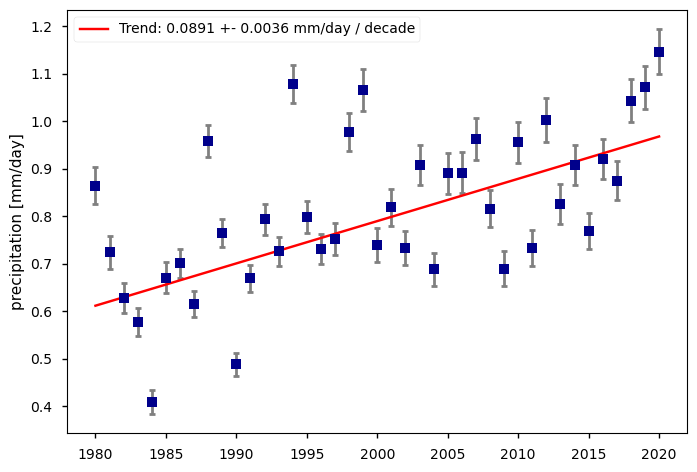

In [7]:
plt.errorbar(X, P, 2*Perr, lw=0, 
             capsize=2, markersize=7, marker='s', color='darkblue', ecolor='gray', elinewidth=2, capthick=2)

plt.plot(X, linear_model(X, *popt), c='r', label=f'Trend: {slope*10:.4f} +- {slope_err*10:.4f} mm/day / decade')

plt.ylabel('precipitation [mm/day]')
plt.legend()

_This plot illustrates the linear fit of precipitation data over time. The blue squares represent the observed precipitation values, while the gray error bars correspond to two times the uncertainty of each measurement. The red line is the best-fit linear model for the data, indicating the trend in precipitation over the period 1980-2020. The trend value is reported in the legend with the 95% confidence interval._

<!-- Surrounding the fitted line, the shaded light coral area represents the 95% confidence interval for the fit, taking into account the uncertainties in the data and the correlation between the fitted parameters. This confidence interval shows the range within which the true trend is likely to fall, providing a visual measure of the uncertainty in the trend estimation. -->

In [8]:
tau, p_value = kendalltau(X, P)

print(f"Kendall's tau: {tau}")
print(f"P-value: {p_value}")
print(f"95% confidence interval for the slope: [{slope - confidence_interval}, {slope + confidence_interval}]")


Kendall's tau: 0.4341463414634146
P-value: 6.372634243195033e-05
95% confidence interval for the slope: [0.008184560846235873, 0.009637063374103593]


The analysis of the precipitation trend using Kendall's tau test yields a tau value of 0.434 and a p-value of $6.37 \times 10^{-5}$. The tau value indicates a positive association, suggesting that precipitation increases with time. The very low p-value indicates that this association is highly statistically significant, meaning that the observed trend is unlikely due to random chance. This implies a significant upward trend in precipitation over the studied period.

## If you want to know more
### Key resources
Some key resources and further reading were linked throughout this assessment.

The CDS catalogue entry for the data used is:
- Precipitation monthly and daily gridded data from 1979 to present derived from satellite measurements:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-precipitation?tab=overview


Code libraries used:
- [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)


### Reference/Useful material
[[1]](https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.ncdc:C00979) Adler, R., Wang, J.J., Sapiano, M., Huffman, G., Chiu, L., Xie, P.P., Ferraro, R., Schneider, U., Becker, A., Bolvin, D., Nelkin, E., Gu, G., and NOAA CDR Program (2016). Global Precipitation Climatology Project (GPCP) Climate Data Record (CDR), Version 2.3 (Monthly). National Centers for Environmental Information. DOI: 10.7289/V56971M6 (Accessed on 20/5/2024)

[[2]](https://www.mdpi.com/2073-4433/9/4/138) Adler, R.F.; Sapiano, M.R.P.; Huffman, G.J.; Wang, J.-J.; Gu, G.; Bolvin, D.; Chiu, L.; Schneider, U.; Becker, A.; Nelkin, E.; et al. The Global Precipitation Climatology Project (GPCP) Monthly Analysis (New Version 2.3) and a Review of 2017 Global Precipitation. Atmosphere 2018, 9, 138. https://doi.org/10.3390/atmos9040138 

[[3]](https://link.springer.com/article/10.1007/s00382-022-06567-9) Gu, G., Adler, R.F. Observed variability and trends in global precipitation during 1979–2020. Clim Dyn 61, 131–150 (2023). https://doi.org/10.1007/s00382-022-06567-9

[[4]](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98JD00995) Weatherhead, E. C., Reinsel, G. C., Tiao, G. C., Meng, X.-L., Choi, D., Cheang, W.-K., Keller, T., DeLuisi, J., Wuebbles, D. J., Kerr, J. B., Miller, A. J., Oltmans, S. J., and Frederick, J. E.: Factors af-
fecting the detection of trends: Statistical considerations and applications to environmental data, J. Geophys. Res.-Atmos., 103, 17149–17161, https://doi.org/10.1029/98JD00995, 1998.

[[5]](https://doi.org/10.1002/wcc.591) Biasutti M. Rainfall trends in the African Sahel: Characteristics, processes, and causes. WIREs Clim Change. 2019; 10:e591. https://doi.org/10.1002/wcc.591